In [1]:
!pip install diffusers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display
import logging
from pathlib import Path
from huggingface_hub import notebook_login

In [3]:
logging.disable(logging.WARNING)
if not (Path.home()/'.huggingface'/'token').exists(): 
    notebook_login()

In [4]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)

In [5]:
def prep_text(prompts):

    text_inputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embeddings = text_encoder(
        text_inputs.input_ids.to("cuda")
    )[0].half()

    mix_embedding = torch.mean(
        text_embeddings, 
        dim=0
    ).unsqueeze(dim=0)

    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to("cuda")
    )[0].half()

    return torch.cat([uncond_embedding, mix_embedding])

In [6]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(
            tfms.ToTensor()(img).unsqueeze(0).to("cuda").half()
            )
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

In [7]:
def decode(latent):
    with torch.no_grad():
        img = vae.decode(1 / 0.18215 * latent).sample

    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

In [8]:
def MixPrompt(
    prompts, 
    steps=50,
    guidance_scale=7.5, 
    seed=32,
    height=512,
    width=512,
    ):

    text_embeddings = prep_text(prompts)

    scheduler.set_timesteps(steps)

    torch.manual_seed(seed)
    latents = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to("cuda").half()
    latents = latents * scheduler.init_noise_sigma

    for i, t in enumerate(tqdm(scheduler.timesteps)):

        input = torch.cat([latents]*2)
        input = scheduler.scale_model_input(input, t)

        with torch.no_grad():
            pred = unet(
                input, 
                t,
                encoder_hidden_states=text_embeddings,
            ).sample

        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        latents = scheduler.step(pred, t, latents).prev_sample

    image = decode(latents)
    display.display(image)

  0%|          | 0/50 [00:00<?, ?it/s]

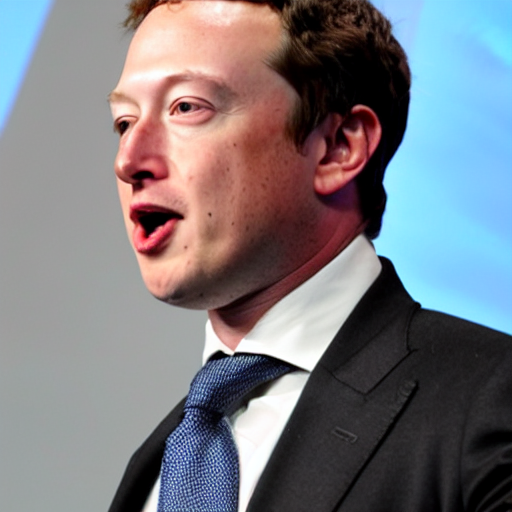

  0%|          | 0/50 [00:00<?, ?it/s]

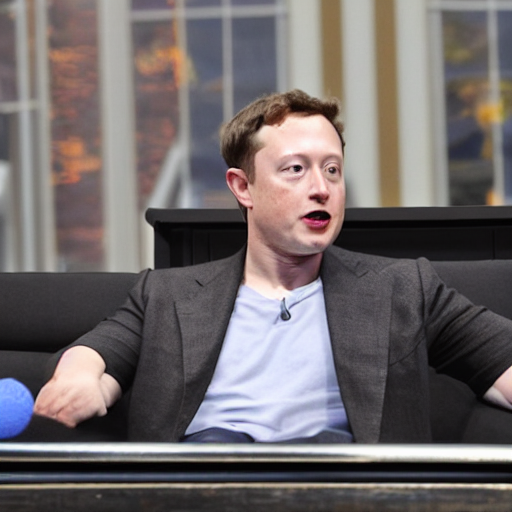

  0%|          | 0/50 [00:00<?, ?it/s]

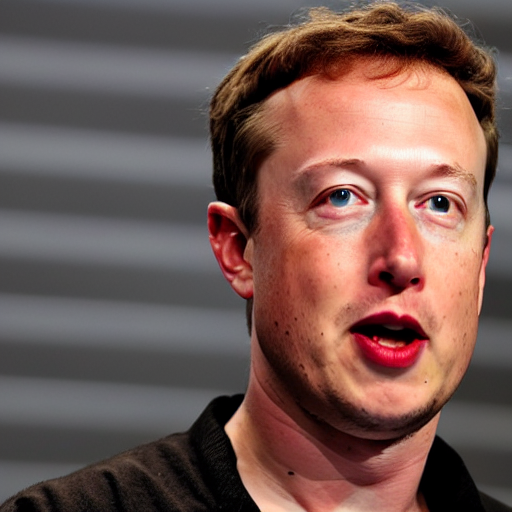

  0%|          | 0/50 [00:00<?, ?it/s]

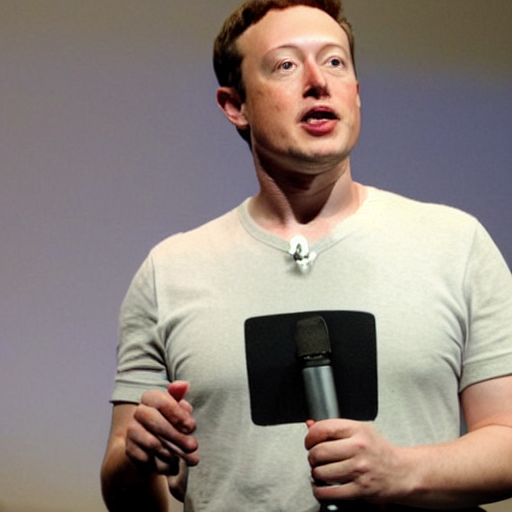

  0%|          | 0/50 [00:00<?, ?it/s]

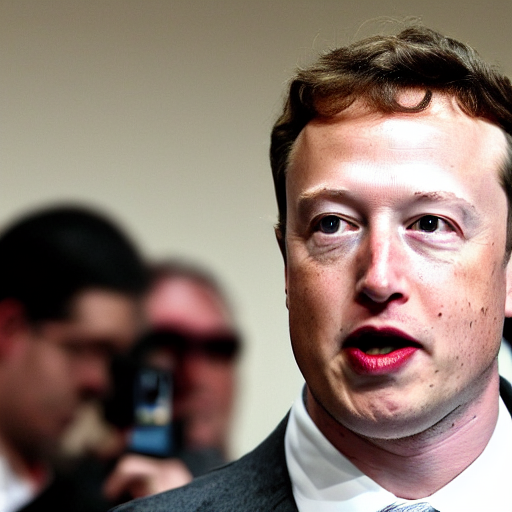

  0%|          | 0/50 [00:00<?, ?it/s]

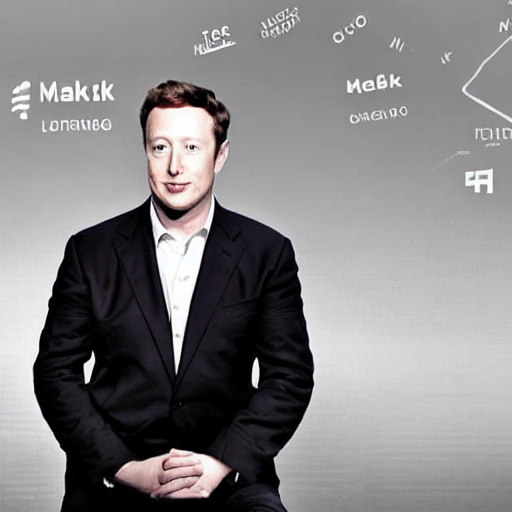

In [15]:
prompts=[
    "mark zuckerberg", 
    "elon musk",
    ]
for seed in [2, 8, 32, 64, 512, 1024]:
    MixPrompt(
        prompts,
        steps=50,
        guidance_scale=7.5, 
        seed=seed,
        height=512,
        width=512,
    )